In [1]:
!pip install python-chess numpy numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=fabe2f996799edae2ec7550a8e5504744eea23fdb215adcba1ccdac0c953c70d
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import requests
requests.get('http://www.google.com',timeout=10).ok


True

In [3]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [4]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



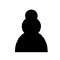
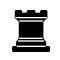
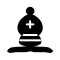
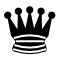
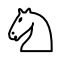
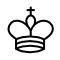
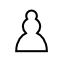
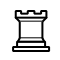
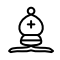
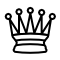
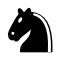
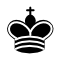

In [5]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

 Chess bot
    - RAM: 5MB max
    - CPU: Single 2.20GHz core
    - Tamaño: <64KB comprimido
    - Tiempo: 0.1s simple delay
    - RAM total controlada: ~4.8MB
    - Valores y tablas compactas (~800KB total)
    - PST minimalistas pero efectivas

https://www.chessprogramming.org/Simplified_Evaluation_Function

In [6]:
%%writefile main.py
#vesion 5.1(base)
import time
import random
from Chessnut import Game

piece_values = {
    'P': 100, 'N': 320, 'B': 330, 'R': 500, 'Q': 900, 'K': 20000
}

piece_square_tables = {
    'P': [
         0,   0,   0,   0,   0,   0,   0,   0,
        50,  50,  50,  50,  50,  50,  50,  50,
        10,  10,  20,  30,  30,  20,  10,  10,
         5,   5,  10,  25,  25,  10,   5,   5,
         0,   0,   0,  20,  20,   0,   0,   0,
         5,  -5, -10,   0,   0, -10,  -5,   5,
         5,  10,  10, -20, -20, 10,  10,   5,
         0,   0,   0,   0,   0,  0,   0,   0
    ],
    'N': [
        -50, -40, -30, -30, -30, -30, -40, -50,
        -40, -20,   0,   5,   5,   0, -20, -40,
        -30,   5,  10,  15,  15,  10,   5, -30,
        -30,   0,  15,  20,  20,  15,   0, -30,
        -30,   5,  15,  20,  20,  15,   5, -30,
        -30,   0,  10,  15,  15,  10,   0, -30,
        -40, -20,   0,   0,   0,   0, -20, -40,
        -50, -40, -30, -30, -30, -30, -40, -50
    ],
    'B': [
        -20, -10, -10, -10, -10, -10, -10, -20,
        -10,   0,   0,   0,   0,   0,   0, -10,
        -10,   0,   5,  10,  10,   5,   0, -10,
        -10,   5,   5,  10,  10,   5,   5, -10,
        -10,   0,  10,  10,  10,  10,   0, -10,
        -10,  10,  10,  10,  10,  10,  10, -10,
        -10,   5,   0,   0,   0,   0,   5, -10,
        -20, -10, -10, -10, -10, -10, -10, -20
    ],
    'R': [
          0,   0,   0,   5,   5,   0,   0,   0,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        -5,   0,   0,   0,   0,   0,   0,  -5,
         5,  10,  10,  10,  10,  10,  10,   5,
          0,   0,   0,   0,   0,   0,   0,   0
    ],
    'Q': [
        -20, -10, -10,  -5,  -5, -10, -10, -20,
        -10,   0,   0,   0,   0,   0,   0, -10,
        -10,   0,   5,   5,   5,   5,   0, -10,
         -5,   0,   5,   5,   5,   5,   0,  -5,
          0,   0,   5,   5,   5,   5,   0,  -5,
        -10,   5,   5,   5,   5,   5,   0, -10,
        -10,   0,   5,   0,   0,   0,   0, -10,
        -20, -10, -10,  -5,  -5, -10, -10, -20
    ],
    'K': [
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -20, -30, -30, -40, -40, -30, -30, -20,
        -10, -20, -20, -20, -20, -20, -20, -10,
         20,  20,   0,   0,   0,   0,  20,  20,
         20,  30,  10,   0,   0,  10,  30,  20
    ]
}

def evaluate_position(board):
    score = 0
    for square in range(64):
        piece = board.get_piece(square)
        if piece != ' ':
            is_white = piece.isupper()
            piece_symbol = piece.upper()
            value = piece_values.get(piece_symbol, 0)
            position_value = 0
            if piece_symbol in piece_square_tables:
                table = piece_square_tables[piece_symbol]
                index = square if is_white else 63 - square
                position_value = table[index]
            piece_score = value + position_value
            score += piece_score if is_white else -piece_score
    return score

def make_move(move, time_to_start_thinking, is_execute_print=True):
    duration = round(time.time() - time_to_start_thinking, 3)
    if is_execute_print:
        print(f'[{move}, {duration}]')
    return move

def quiescence_search(game, alpha, beta, maximizing, time_start, max_time):
    if time.time() - time_start > max_time:
        return evaluate_position(game.board)
    stand_pat = evaluate_position(game.board)
    if maximizing:
        if stand_pat >= beta:
            return beta
        if alpha < stand_pat:
            alpha = stand_pat
    else:
        if stand_pat <= alpha:
            return alpha
        if beta > stand_pat:
            beta = stand_pat
    moves = [move for move in game.get_moves() if game.board.get_piece(Game.xy2i(move[2:4])) != ' ']
    for move in moves:
        g = Game(game.get_fen())
        g.apply_move(move)
        score = quiescence_search(g, alpha, beta, not maximizing, time_start, max_time)
        if maximizing:
            if score >= beta:
                return beta
            if score > alpha:
                alpha = score
        else:
            if score <= alpha:
                return alpha
            if score < beta:
                beta = score
    return alpha if maximizing else beta

def alpha_beta(game, depth, alpha, beta, maximizing, time_start, max_time):
    if time.time() - time_start > max_time:
        return None, evaluate_position(game.board)
    if depth == 0:
        score = quiescence_search(game, alpha, beta, maximizing, time_start, max_time)
        return None, score
    moves = list(game.get_moves())
    if not moves:
        return None, evaluate_position(game.board)
    best_move = None
    if maximizing:
        max_eval = float('-inf')
        for move in moves:
            g = Game(game.get_fen())
            g.apply_move(move)
            _, eval_score = alpha_beta(g, depth - 1, alpha, beta, False, time_start, max_time)
            if eval_score > max_eval:
                max_eval = eval_score
                best_move = move
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break
        return best_move, max_eval
    else:
        min_eval = float('inf')
        for move in moves:
            g = Game(game.get_fen())
            g.apply_move(move)
            _, eval_score = alpha_beta(g, depth - 1, alpha, beta, True, time_start, max_time)
            if eval_score < min_eval:
                min_eval = eval_score
                best_move = move
            beta = min(beta, eval_score)
            if beta <= alpha:
                break
        return best_move, min_eval

def chess_bot(obs):
    time_start = time.time()
    max_time = 0.095  # Tiempo máximo por movimiento en segundos
    game = Game(obs.board)
    moves = list(game.get_moves())
    is_white = obs.mark == 'white'

    # Mantener aperturas
    if is_white:
        if obs.step == 0 and 'e2e4' in moves:
            return make_move('e2e4', time_start)
        if obs.step == 2 and 'g1f3' in moves:
            return make_move('g1f3', time_start)
        if obs.step == 4 and 'f1c4' in moves:
            return make_move('f1c4', time_start)
    else:
        if obs.step == 1 and 'e7e5' in moves:
            return make_move('e7e5', time_start)
        if obs.step == 3 and 'b8c6' in moves:
            return make_move('b8c6', time_start)
        if obs.step == 5 and 'g8f6' in moves:
            return make_move('g8f6', time_start)

    # Verificar mates en un movimiento
    for move in moves:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return make_move(move, time_start)

    # Iterative Deepening
    best_move = None
    depth = 1
    while time.time() - time_start < max_time:
        move, score = alpha_beta(game, depth, float('-inf'), float('inf'), is_white, time_start, max_time)
        if move:
            best_move = move
        depth += 1

    if best_move:
        return make_move(best_move, time_start)

    # Movimiento de respaldo: captura o aleatorio
    captures = [move for move in moves if game.board.get_piece(Game.xy2i(move[2:4])) != ' ']
    if captures:
        return make_move(random.choice(captures), time_start)
    return make_move(random.choice(moves), time_start)

Writing main.py


[e2e4, 0.004]
[g1f3, 0.006]
[f1c4, 0.006]
[c4g8, 0.223]
[g8h7, 0.191]
[c2c3, 0.225]
[h1g1, 0.236]
[b2b4, 0.184]
[d1b3, 0.185]
[c3b4, 0.286]
[f3g5, 0.257]
[g5e6, 0.355]
[e6c7, 0.384]
[c7b5, 0.358]
[b5a7, 0.371]
[a7c6, 0.387]
[c6b8, 0.438]
[e1d1, 0.4]
[b8a6, 0.385]
[b1c3, 0.268]
[f2f3, 0.24]
[a2a3, 0.236]
[h7g6, 0.255]
[d1e2, 0.141]
[c3a2, 0.292]
[h2h3, 0.256]
[g1f1, 0.196]
[b3f7, 0.226]
[f7f8, 0.181]
[f8d6, 0.139]
[d6f4, 0.121]
[g6f5, 0.105]
[a2c3, 0.13]
[f4h2, 0.137]
[f5h7, 0.095]
[d2d4, 0.121]
[c3b1, 0.134]
[b1c3, 0.121]
[c3d1, 0.132]
[d1e3, 0.123]
[h7f5, 0.124]
[f5e6, 0.12]
[a1a2, 0.114]
[b4b5, 0.111]
[e3d5, 0.114]
[h2b8, 0.088]
Agent exit status/reward/time left: 
	 DONE / 1 / 5.093405999999999
	 DONE / 0 / 10





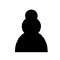
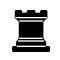
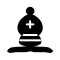
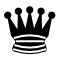
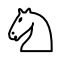
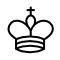
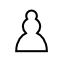
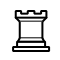
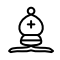
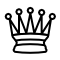
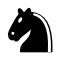
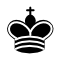

In [7]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=500, height=500) 